# Kobak and Berens approach

In [1]:
from time import time
from datetime import datetime
from pathlib import Path
import numpy as np
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

import numpy as np
import matplotlib.pyplot as plt
import sys
import seaborn as sns

sns.set_style('ticks')

sys.path.insert(0, r"C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB")
from src.utils.load_dataset import get_mnist, get_fmnist, load_flow18, load_wong, load_celegans, get_tasic2018

# the path should point to the FIt-SNE directory
sys.path.append('../FIt-SNE')
from fast_tsne import fast_tsne

In [2]:
def get_dataset(dataset_id):
    """
    Given the name of a data set, load the corresponding data set.
    Parameters
    ----------
    dataset_id : String
        Number of points to be embedded in total
    Returns
    -------
    dataset_id, X, labels : String, CSR_matrix, list[]
        Name of the data set, the data, data labels
    """

    if dataset_id == "mnist":
        print("Loading MNIST data")
        mnist_data_dir = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/mnist")
        return ["mnist", ] + list(get_mnist(mnist_data_dir))
    elif dataset_id == "wong":
        wong_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/wong")
        result = load_wong(data_home= wong_path, labels_name="broad", return_colors=False)
        X, labels = result
        return ["wong", X, labels]
    elif dataset_id == "flow18":
        flow18_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main/mg-emb-exps-main/data/flow18/flow18_annotated.fcs")
        X, labels = load_flow18(flow18_path)
        return ["flow18", X, labels]
    elif dataset_id == "c_elegans":
        celegans_path = Path("C:/Users/arsla/my_files/research_project/mg-emb-exps-main-KB/mg-emb-exps-main-KB/data/c_elegans")
        X, labels = load_celegans(data_home=celegans_path, return_X_y=True)
        return ["c_elegans", X, labels]       
    else:
        print("[perp-vs-num_samples] Dataset `{}` not supported.".format(dataset_id))

#### plotting and saving logic

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_kb_tsne_embedding(embedding, labels, quality, title="kb-tsne embedding", panel_letter=None):
    """
    Plot a 2D t-SNE embedding with quality metrics annotated on the figure.

    Parameters:
        embedding (np.ndarray): 2D embedding of shape (n_samples, 2).
        labels (np.ndarray): Cluster/class labels for each point.
        quality (tuple): (kNN, KNC, CPD) metrics.
        title (str): Title of the plot.
        panel_letter (str or None): Optional panel letter for annotation.
    """
    knn, knc, cpd = quality

    sns.set(style="white")
    fig = plt.figure(figsize=(7, 7))
    ax = plt.gca()
    ax.set_aspect('equal', adjustable='datalim')

    ax.scatter(
        embedding[:, 0], embedding[:, 1],
        s=2, c=labels, cmap="tab10", edgecolor='none', rasterized=True
    )

    ax.set_title(title, va='center')
    ax.text(0.75, .02, 'KNN:\nKNC:\nCPD:', transform=ax.transAxes, fontsize=16)
    ax.text(0.87, .02, '{:.2f}\n{:.2f}\n{:.2f}'.format(knn, knc, cpd), transform=ax.transAxes, fontsize=16)

    if panel_letter:
        ax.text(0, 1.05, panel_letter, transform=ax.transAxes, fontsize=8, fontweight='bold')

    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, left=True, bottom=True)
    plt.tight_layout()
    plt.show()

    return fig


In [4]:
def save_fig(figure, dataset_id, fname, overwrite=False):

    # Get current date formatted as dd-mm-yy
    folder_timestamp = datetime.now().strftime("%d-%m-%y")

    if dataset_id is not None:
        figures_dir = Path.cwd() / "figures" / "kobak-berens" /dataset_id / folder_timestamp
        figures_dir.mkdir(parents=True, exist_ok=True)
    else:
        # Default figures directory
        figures_dir = Path.cwd() / "figures" / "kobak-berens" / "default"
        figures_dir.mkdir(parents=True, exist_ok=True)

    full_path = figures_dir / fname

    if full_path.exists() and not overwrite:
        print(f"File already exists. Remove or rename {full_path} before continuing.")
    else:
        figure.savefig(full_path)
        print(f"Figure saved to {full_path}")

#### Kobak and Berens approach

In [5]:
def kb_tsne(
    initial_embedding,
    rnd_state=42,
    sample_rate=None
):
    
    start = time()
    n = initial_embedding.shape[0]
    print(f"Number of points in the dataset: {n}")
    if n <= 100000:
        print("Dataset is small enough, running fast_tsne directly on the full dataset.")
        # Small dataset: combine perplexities [30, n/100]
        perplist = [30]
        if n / 100 > 30:
            perplist.append(n / 100)
        search_k = int(3 * max(perplist) * 50)  # 50 is the default n_trees
        print("Applying fast_tsne for the small dataset with perplexities:", perplist)
        embedding = fast_tsne(
            initial_embedding,
            perplexity=0,
            perplexity_list=perplist,
            search_k=search_k,
            
            early_exag_coeff=12,
            stop_early_exag_iter=250,
            max_iter=1000,
            
            learning_rate="auto",
            momentum=0.5,
            final_momentum=0.8,

            initialization="pca",
            seed=rnd_state
        )
        print("DONE.")
    else:
        # Very large dataset: sample then prolong
        print("Dataset is too large, sampling and prolonging the embedding...")
        np.random.seed(rnd_state)
        sample_ids = np.random.choice(
            np.arange(0, n),
            size=int(n * sample_rate),
            replace=False
        )
        sample_ids.sort()
        sampled_initial_embedding = initial_embedding[sample_ids, :]

        m = sampled_initial_embedding.shape[0]  # or: int(n * sample_rate)
        print(f"Sampled {m} points from the dataset.")
        perplist = [30]
        if m / 100 > 30:
            perplist.append(m / 100)


        search_k = int(3 * max(perplist) * 50)
        print("Applying fast_tsne for the sampled dataset with perplexities:", perplist)
        sampled_embedding = fast_tsne(
            sampled_initial_embedding,
            perplexity=0,
            perplexity_list=perplist,
            search_k=search_k,
            initialization="pca",
            seed=rnd_state,
            
            early_exag_coeff=12, # default value
            stop_early_exag_iter=250, # default value
            max_iter=1000, # default value
            
            learning_rate="auto", # internally becomes max(200, n/early_exag_coeff)
            momentum=0.5, # defualt value
            final_momentum=0.8 # default value
        )
        print("DONE.")


        print("Prolongating the sampled embedding to full embedding...")
        # Prolongate the sampled embedding to the full dataset
        prolongated_embedding = np.empty((n, 2))
        prolongated_embedding[:] = np.NAN
        prolongated_embedding[sample_ids, :] = sampled_embedding
        nn = NearestNeighbors(n_neighbors=1).fit(sampled_initial_embedding)
        dists, nearest = nn.kneighbors(initial_embedding)
        for i in range(n):
            if np.isnan(prolongated_embedding[i, 0]):
                prolongated_embedding[i, :] = sampled_embedding[nearest[i, 0]]
        print("DONE.")
        

        print("Applying fast_tsne on the prolongated embedding...")
        embedding = fast_tsne(
            initial_embedding,
            perplexity=30,
            initialization=prolongated_embedding,
            seed=rnd_state,
            
            # early_exag_coeff=12, # default value
            # stop_early_exag_iter=250, # default value
            # late_exag_coeff=4,
            # start_late_exag_iter=250, # not explicitly needed to be set, but good to have
            # max_iter=750,

            early_exag_coeff=1.0, # no early exaggeration
            stop_early_exag_iter=0,
            max_iter=750,

            learning_rate="auto",
            momentum=0.5,
            final_momentum=0.5
        )
        print("DONE.")

    print(f"-> Total time for running kb_tsne took {(time() - start) / 60:.2f} minutes.")
    return embedding


#### Embedding Quality method

In [6]:
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist
from scipy.stats import spearmanr

def embedding_quality(X, Z, classes, knn=10, knn_classes=4, subsetsize=1000):
    # Local neighborhood preservation (kNN)
    nbrs1 = NearestNeighbors(n_neighbors=knn).fit(X)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn).fit(Z)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(X.shape[0]):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn = intersections / (X.shape[0] * knn)

    # Global neighborhood consistency (KNC)
    cl, cl_inv = np.unique(classes, return_inverse=True)
    C = cl.size

    mu1 = np.zeros((C, X.shape[1]))
    mu2 = np.zeros((C, Z.shape[1]))
    for c in range(C):
        mu1[c, :] = np.mean(X[cl_inv == c, :], axis=0)
        mu2[c, :] = np.mean(Z[cl_inv == c, :], axis=0)

    knn_classes = min(knn_classes, max(1, C - 1))  # Prevent requesting more neighbors than class centers
    nbrs1 = NearestNeighbors(n_neighbors=knn_classes).fit(mu1)
    ind1 = nbrs1.kneighbors(return_distance=False)

    nbrs2 = NearestNeighbors(n_neighbors=knn_classes).fit(mu2)
    ind2 = nbrs2.kneighbors(return_distance=False)

    intersections = 0.0
    for i in range(C):
        intersections += len(set(ind1[i]) & set(ind2[i]))
    mnn_global = intersections / (C * knn_classes)

    # Spearman correlation of pairwise distances (CPD)
    subset = np.random.choice(X.shape[0], size=subsetsize, replace=False)
    d1 = pdist(X[subset, :])
    d2 = pdist(Z[subset, :])
    rho = spearmanr(d1, d2).correlation

    return mnn, mnn_global, rho

#### Prepare data

In [ ]:
# This sets a fixed seed for any randomized operations (e.g., random sampling, PCA initialization, t-SNE optimization). 
# Using a fixed random seed ensures reproducibility — so you get the same results every time you run the code.
# random_state = 42

# data to be used for the experiment
dataset_id = "mnist"
# dataset_id = "c_elegans"
# dataset_id = "wong"
# dataset_id = "flow18"

# Load data
dataset_name, data_to_be_embedded, labels = get_dataset(dataset_id)

# size of the dataset
num_points = data_to_be_embedded.shape[0]
num_features = data_to_be_embedded.shape[1]
print(f"Dataset `{dataset_name}` has {num_points} points with {num_features} features each.")
print("Number of unique classes:", len(np.unique(labels)))

# for c_elegans, Convert sparse matrix to dense if necessary
if dataset_id == "c_elegans":
    if hasattr(data_to_be_embedded, "toarray"):
        data_to_be_embedded = data_to_be_embedded.toarray()

# Reduce dataset size for flow18
if dataset_id == "flow18":
    rng = np.random.default_rng(seed=42)
    subset_indices = rng.choice(num_points, size=num_points // 2, replace=False)
    data_to_be_embedded = data_to_be_embedded[subset_indices]
    labels = labels[subset_indices]
    print(f"Reduced dataset size to {data_to_be_embedded.shape[0]} points for flow18.")

# Apply PCA to reduce dimensions to 50
print("Applying PCA...")
# Centering the data.
data_to_be_embedded = data_to_be_embedded - data_to_be_embedded.mean(axis=0)
# Decomposing it via SVD.
U, s, V = np.linalg.svd(data_to_be_embedded, full_matrices=False)
U[:, np.sum(V, axis=1) < 0] *= -1
# Projecting onto the top components via U * s.
data_to_be_embedded = np.dot(U, np.diag(s))
initial_embedding = data_to_be_embedded[:, np.argsort(s)[::-1]][:, :50]
print("Done.")

# sampling rate
sample_rate = 0.1

C:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB\mg-emb-exps-main-KB\data\wong
Dataset `wong` has 327457 points with 39 features each.
Number of unique classes: 6
Applying PCA...
Done.


### Run kb_tsne

In [8]:
# Run kb_tsne
print("Running kb_tsne...")
kb_output = kb_tsne(
    initial_embedding=initial_embedding,
    rnd_state=42,
    sample_rate=sample_rate
)
print("finished running kb_tsne.")

final_embedding = kb_output

Running kb_tsne...
Number of points in the dataset: 327457
Dataset is too large, sampling and prolonging the embedding...
Sampled 32745 points from the dataset.
Applying fast_tsne for the sampled dataset with perplexities: [30, 327.45]
DONE.
Prolongating the sampled embedding to full embedding...
DONE.
Applying fast_tsne on the prolongated embedding...
DONE.
-> Total time for running kb_tsne took 6.69 minutes.
finished running kb_tsne.


In [9]:
final_embedding = kb_output
subset_size = 1000

kb_mnn, kb_knc, kb_cpd = embedding_quality(
    initial_embedding, final_embedding, labels, knn=10, knn_classes=4, subsetsize=subset_size
)

print(f"KB t-SNE:  kNN={kb_mnn:.4f}, KNC={kb_knc:.4f}, CPD={kb_cpd:.4f}")

KB t-SNE:  kNN=0.1481, KNC=0.7500, CPD=0.5493


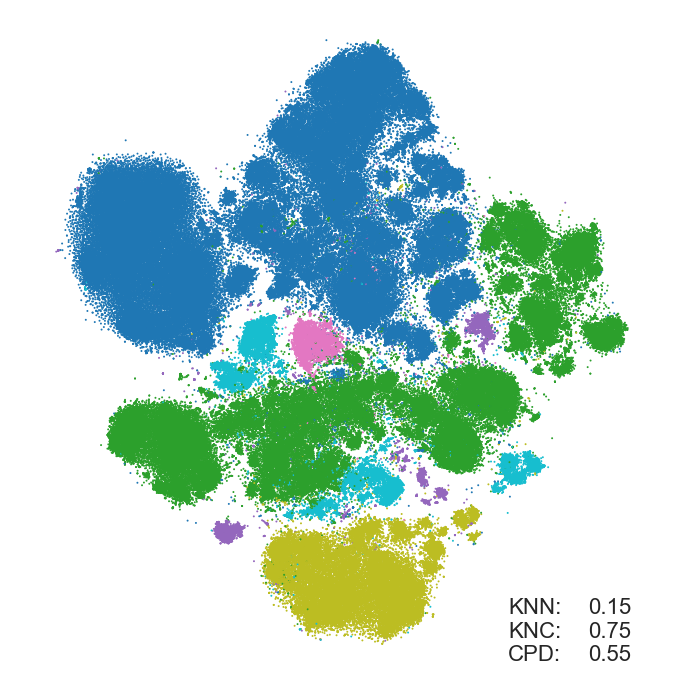

Figure saved to c:\Users\arsla\my_files\research_project\mg-emb-exps-main-KB-2\mg-emb-exps-main-KB\src\figures\kobak-berens\wong\22-06-25\wong_~_22-06-25-05-16.png


In [12]:
quality = (kb_mnn, kb_knc, kb_cpd)

fig = plot_kb_tsne_embedding(
    embedding=final_embedding,
    labels=labels,
    quality=quality,
    title="",
    panel_letter=None
)

timestamp_kb = datetime.now().strftime("%d-%m-%y-%H-%M")
filename_kb = f"{dataset_id}_~_{timestamp_kb}.png"
save_fig(fig, dataset_id, filename_kb, overwrite=True)